ЗАДАНИЕ 1.

Обучите нейронную сеть любой архитектуры которой не было на курсе, либо обучите нейронную сеть разобранной архитектуры, но на том датасете, которого не было на уроках. Сделайте анализ, того, что вам помогло в улучшения работы нейронной сети.

Используется сеть типа Transformer, где имплементируется блок Transformer как  Keras слой для классификации текста отзыва о фильме.
Анализируются зависимости качества модели (roc_auc метрика) от разных параметров:


In [1]:
"""
Title: Text classification with Transformer
Author: [Apoorv Nandan](https://twitter.com/NandanApoorv), 
        также я добавил класс ModelCreation для удобства тестирования и использования
Date created: 2020/05/10
Last modified: 2020/05/10
Description: Implement a Transformer block as a Keras layer and use it for text classification.
"""
"""
## Setup
"""

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

"""
## Implement multi head self attention as a Keras layer
"""


class MultiHeadSelfAttention(layers.Layer):
    def __init__(self, embed_dim, num_heads=8):
        super(MultiHeadSelfAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        if embed_dim % num_heads != 0:
            raise ValueError(
                f"embedding dimension = {embed_dim} should be divisible by number of heads = {num_heads}"
            )
        self.projection_dim = embed_dim // num_heads
        self.query_dense = layers.Dense(embed_dim)
        self.key_dense = layers.Dense(embed_dim)
        self.value_dense = layers.Dense(embed_dim)
        self.combine_heads = layers.Dense(embed_dim)

    def attention(self, query, key, value):
        score = tf.matmul(query, key, transpose_b=True)
        dim_key = tf.cast(tf.shape(key)[-1], tf.float32)
        scaled_score = score / tf.math.sqrt(dim_key)
        weights = tf.nn.softmax(scaled_score, axis=-1)
        output = tf.matmul(weights, value)
        return output, weights

    def separate_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs):
        # x.shape = [batch_size, seq_len, embedding_dim]
        batch_size = tf.shape(inputs)[0]
        query = self.query_dense(inputs)  # (batch_size, seq_len, embed_dim)
        key = self.key_dense(inputs)  # (batch_size, seq_len, embed_dim)
        value = self.value_dense(inputs)  # (batch_size, seq_len, embed_dim)
        query = self.separate_heads(
            query, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        key = self.separate_heads(
            key, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        value = self.separate_heads(
            value, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        attention, weights = self.attention(query, key, value)
        attention = tf.transpose(
            attention, perm=[0, 2, 1, 3]
        )  # (batch_size, seq_len, num_heads, projection_dim)
        concat_attention = tf.reshape(
            attention, (batch_size, -1, self.embed_dim)
        )  # (batch_size, seq_len, embed_dim)
        output = self.combine_heads(
            concat_attention
        )  # (batch_size, seq_len, embed_dim)
        return output


"""
## Implement a Transformer block as a layer
"""


class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadSelfAttention(embed_dim, num_heads)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)


"""
## Implement embedding layer
Two seperate embedding layers, one for tokens, one for token index (positions).
"""


class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions






"""
## Create classifier model using transformer layer
Transformer layer outputs one vector for each time step of our input sequence.
Here, we take the mean across all time steps and
use a feed forward network on top of it to classify text.
"""

class ModelCreation:
     def __init__(self, maxlen, vocab_size, embed_dim, num_heads, ff_dim):
            inputs = layers.Input(shape=(maxlen,))
            embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
            x = embedding_layer(inputs)
            transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
            x = transformer_block(x)
            x = layers.GlobalAveragePooling1D()(x)
            x = layers.Dropout(0.1)(x)
            x = layers.Dense(20, activation="relu")(x)
            x = layers.Dropout(0.1)(x)
            outputs = layers.Dense(2, activation="softmax")(x)
            self.model = keras.Model(inputs=inputs, outputs=outputs)
            
            
     def train(self, x_train, y_train, x_val, y_val, batch_size, epochs):
        
        """
        ## Train and Evaluate
        """
        self.model.compile("adam", "sparse_categorical_crossentropy", metrics=["accuracy"])
        history = self.model.fit(
            x_train, y_train, batch_size, epochs, validation_data=(x_val, y_val)
        )
        return self.model,history

In [2]:
"""
## Download and prepare dataset
"""

vocab_size = 20000  # Only consider the top 20k words
maxlen = 200  # Only consider the first 200 words of each movie review
(x_train, y_train), (x_val, y_val) = keras.datasets.imdb.load_data(num_words=vocab_size)
print(len(x_train), "Training sequences")
print(len(x_val), "Validation sequences")
x_train = keras.preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_val = keras.preprocessing.sequence.pad_sequences(x_val, maxlen=maxlen)

C:\Users\Windows\Anaconda3\lib\site-packages\tensorflow_core\python\keras\datasets\imdb.py:129: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
C:\Users\Windows\Anaconda3\lib\site-packages\tensorflow_core\python\keras\datasets\imdb.py:130: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_test, y_test = np.array(xs[idx:]), np.array(labels[idx:])


25000 Training sequences
25000 Validation sequences


In [3]:
embed_dim = 32  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

batch_size=32
epochs=2

In [4]:
model_creation=ModelCreation(maxlen, vocab_size, embed_dim, num_heads, ff_dim)
model,hist=model_creation.train(x_train, y_train,x_val, y_val, batch_size, epochs)

Train on 25000 samples, validate on 25000 samples
Epoch 1/2
25000/25000 [==============================] - 31s 1ms/sample - loss: 0.3708 - accuracy: 0.8286 - val_loss: 0.2975 - val_accuracy: 0.8769
Epoch 2/2
25000/25000 [==============================] - 30s 1ms/sample - loss: 0.1962 - accuracy: 0.9268 - val_loss: 0.3397 - val_accuracy: 0.8552


In [5]:
hist.history.get('accuracy')[-1]

0.92676

In [6]:
y_pred=model.predict(x_val)

In [7]:
print('y_val.shape',y_val.shape)
print('y_pred.shape',y_pred.shape)

y_val.shape (25000,)
y_pred.shape (25000, 2)


In [8]:
from sklearn.metrics import roc_auc_score

In [9]:
round(roc_auc_score(y_val,y_pred[:, 1]),2)

0.94

In [10]:
#Зависимость roc_auc_score от batch_size
batch_sizes=[16,32,64,128]
roc_auc_scores=[]
for batch_size in batch_sizes:
    model_creation=ModelCreation(maxlen, vocab_size, embed_dim, num_heads, ff_dim)
    model,hist=model_creation.train(x_train, y_train,x_val, y_val, batch_size, epochs)
    y_pred=model.predict(x_val)
    roc_auc_scores.append(round(roc_auc_score(y_val,y_pred[:, 1]),2))
    
    

Train on 25000 samples, validate on 25000 samples
Epoch 1/2
25000/25000 [==============================] - 35s 1ms/sample - loss: 0.3709 - accuracy: 0.8301 - val_loss: 0.2933 - val_accuracy: 0.8702
Epoch 2/2
25000/25000 [==============================] - 32s 1ms/sample - loss: 0.2053 - accuracy: 0.9233 - val_loss: 0.3173 - val_accuracy: 0.8669
Train on 25000 samples, validate on 25000 samples
Epoch 1/2
25000/25000 [==============================] - 30s 1ms/sample - loss: 0.3769 - accuracy: 0.8256 - val_loss: 0.3074 - val_accuracy: 0.8719
Epoch 2/2
25000/25000 [==============================] - 28s 1ms/sample - loss: 0.2043 - accuracy: 0.9208 - val_loss: 0.3203 - val_accuracy: 0.8700
Train on 25000 samples, validate on 25000 samples
Epoch 1/2
25000/25000 [==============================] - 36s 1ms/sample - loss: 0.4106 - accuracy: 0.8042 - val_loss: 0.3026 - val_accuracy: 0.8696
Epoch 2/2
25000/25000 [==============================] - 34s 1ms/sample - loss: 0.2068 - accuracy: 0.9218 - va

In [11]:
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

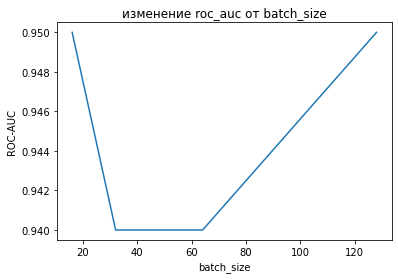

In [12]:
plt.plot(batch_sizes,roc_auc_scores)
plt.title("изменение roc_auc от batch_size")
plt.xlabel('batch_size')
plt.ylabel('ROC-AUC')
plt.show()

**Вывод - наилучший batch_size=128 и batch_size=16**

In [13]:
#Зависимость roc_auc_score от epochs
embed_dim = 32  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

batch_size=32

epochses=[2,4,8]
roc_auc_scores=[]
for epochs in epochses:
    model_creation=ModelCreation(maxlen, vocab_size, embed_dim, num_heads, ff_dim)
    model,hist=model_creation.train(x_train, y_train,x_val, y_val, batch_size, epochs)
    y_pred=model.predict(x_val)
    roc_auc_scores.append(round(roc_auc_score(y_val,y_pred[:, 1]),2))

Train on 25000 samples, validate on 25000 samples
Epoch 1/2
25000/25000 [==============================] - 34s 1ms/sample - loss: 0.3842 - accuracy: 0.8189 - val_loss: 0.3071 - val_accuracy: 0.8704
Epoch 2/2
25000/25000 [==============================] - 33s 1ms/sample - loss: 0.2051 - accuracy: 0.9216 - val_loss: 0.3101 - val_accuracy: 0.8714
Train on 25000 samples, validate on 25000 samples
Epoch 1/4
25000/25000 [==============================] - 33s 1ms/sample - loss: 0.3860 - accuracy: 0.8156 - val_loss: 0.2884 - val_accuracy: 0.8765
Epoch 2/4
25000/25000 [==============================] - 33s 1ms/sample - loss: 0.2030 - accuracy: 0.9216 - val_loss: 0.3118 - val_accuracy: 0.8738
Epoch 3/4
25000/25000 [==============================] - 32s 1ms/sample - loss: 0.1396 - accuracy: 0.9494 - val_loss: 0.3623 - val_accuracy: 0.8612
Epoch 4/4
25000/25000 [==============================] - 32s 1ms/sample - loss: 0.0956 - accuracy: 0.9673 - val_loss: 0.4662 - val_accuracy: 0.8566
Train on 250

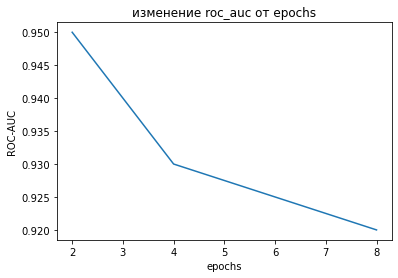

In [14]:
plt.plot(epochses,roc_auc_scores)
plt.title("изменение roc_auc от epochs")
plt.xlabel('epochs')
plt.ylabel('ROC-AUC')
plt.show()

**Вывод - наилучшее количество эпох - итераций epochs=2**

In [15]:
#Зависимость roc_auc_score от embed_dim - Embedding size for each token - Размер встраивания для каждого токена

num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

batch_size=32
epochs=2

embed_dims=[16,32,64,128]
roc_auc_scores=[]
for embed_dim in embed_dims:
    ff_dim=embed_dim
    model_creation=ModelCreation(maxlen, vocab_size, embed_dim, num_heads, ff_dim)
    model,hist=model_creation.train(x_train, y_train,x_val, y_val, batch_size, epochs)
    y_pred=model.predict(x_val)
    roc_auc_scores.append(round(roc_auc_score(y_val,y_pred[:, 1]),2))

Train on 25000 samples, validate on 25000 samples
Epoch 1/2
25000/25000 [==============================] - 25s 1ms/sample - loss: 0.4131 - accuracy: 0.7980 - val_loss: 0.3305 - val_accuracy: 0.8610
Epoch 2/2
25000/25000 [==============================] - 24s 971us/sample - loss: 0.2096 - accuracy: 0.9206 - val_loss: 0.3138 - val_accuracy: 0.8678
Train on 25000 samples, validate on 25000 samples
Epoch 1/2
25000/25000 [==============================] - 31s 1ms/sample - loss: 0.3796 - accuracy: 0.8242 - val_loss: 0.2887 - val_accuracy: 0.8783
Epoch 2/2
25000/25000 [==============================] - 31s 1ms/sample - loss: 0.1981 - accuracy: 0.9248 - val_loss: 0.3308 - val_accuracy: 0.8704
Train on 25000 samples, validate on 25000 samples
Epoch 1/2
25000/25000 [==============================] - 55s 2ms/sample - loss: 0.3741 - accuracy: 0.8217 - val_loss: 0.2864 - val_accuracy: 0.8779
Epoch 2/2
25000/25000 [==============================] - 53s 2ms/sample - loss: 0.1941 - accuracy: 0.9254 - 

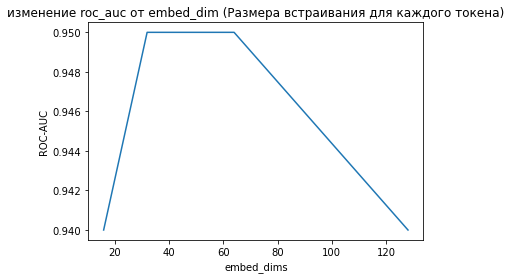

In [16]:
plt.plot(embed_dims,roc_auc_scores)
plt.title("изменение roc_auc от embed_dim (Размера встраивания для каждого токена)")
plt.xlabel('embed_dims')
plt.ylabel('ROC-AUC')
plt.show()

**Вывод - наилучший размера встраивания для каждого токена - embed_dim>30 и embed_dim<70**

In [17]:
#Зависимость roc_auc_score от num_heads - Number of attention heads - Количество заголовков внимания

ff_dim = 32  # Hidden layer size in feed forward network inside transformer
embed_dim=32
batch_size=32
epochs=2

num_headses=[2,4,8,16]
roc_auc_scores=[]
for num_heads in num_headses:
    model_creation=ModelCreation(maxlen, vocab_size, embed_dim, num_heads, ff_dim)
    model,hist=model_creation.train(x_train, y_train,x_val, y_val, batch_size, epochs)
    y_pred=model.predict(x_val)
    roc_auc_scores.append(round(roc_auc_score(y_val,y_pred[:, 1]),2))

Train on 25000 samples, validate on 25000 samples
Epoch 1/2
25000/25000 [==============================] - 33s 1ms/sample - loss: 0.3809 - accuracy: 0.8238 - val_loss: 0.2995 - val_accuracy: 0.8758
Epoch 2/2
25000/25000 [==============================] - 30s 1ms/sample - loss: 0.2001 - accuracy: 0.9236 - val_loss: 0.3165 - val_accuracy: 0.8710
Train on 25000 samples, validate on 25000 samples
Epoch 1/2
25000/25000 [==============================] - 54s 2ms/sample - loss: 0.3894 - accuracy: 0.8136 - val_loss: 0.3180 - val_accuracy: 0.8678
Epoch 2/2
25000/25000 [==============================] - 52s 2ms/sample - loss: 0.2025 - accuracy: 0.9227 - val_loss: 0.3344 - val_accuracy: 0.8625
Train on 25000 samples, validate on 25000 samples
Epoch 1/2
25000/25000 [==============================] - 86s 3ms/sample - loss: 0.3755 - accuracy: 0.8265 - val_loss: 0.2973 - val_accuracy: 0.8728
Epoch 2/2
25000/25000 [==============================] - 84s 3ms/sample - loss: 0.2043 - accuracy: 0.9214 - va

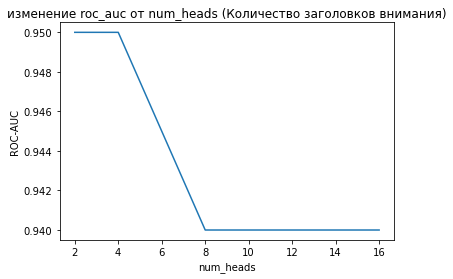

In [18]:
plt.plot(num_headses,roc_auc_scores)
plt.title("изменение roc_auc от num_heads (Количество заголовков внимания)")
plt.xlabel('num_heads')
plt.ylabel('ROC-AUC')
plt.show()

**Вывод - наилучшее num_heads (Количество заголовков внимания)num_heads<=4**